In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd
import torchvision.models as models
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
from collections import OrderedDict

import src.voc_dataset_2 as voc_dataset
import src.faster_rcnn as faster_rcnn
import src.roi_pooling.roi_pooling as roi_pooling
import src.anchor_util as anchor_util
import src.nms as nms
import time

In [132]:
dataset = voc_dataset.VOCDataSetROIs("data/", "train", 1000, roi_path="data/ROIs/")
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=5, collate_fn=voc_dataset.collate_rois_fn)
iterator = iter(dataloader)
net = faster_rcnn.FasterRCNN().cuda()
softmax = nn.Softmax().cuda()

checkpoint = torch.load("data/Experiments/train_fast_rcnn_1_cont/checkpoints/checkpoint_15.tar")
net.load_state_dict(checkpoint["state_dict"])
net.train(mode=False)

FasterRCNN (
  (_features): Sequential (
    (Conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Relu1_1): ReLU (inplace)
    (Conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Relu1_2): ReLU (inplace)
    (MaxPool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (Conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Relu2_1): ReLU (inplace)
    (Conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Relu2_2): ReLU (inplace)
    (MaxPool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (Conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Relu3_1): ReLU (inplace)
    (Conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Relu3_2): ReLU (inplace)
    (Conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Relu3_3): ReLU (inplace)
    (MaxPool3): MaxPool2d (siz

In [202]:
indices, image_arr, bboxes, labels, regression_targets, regression_weights, image_info = next(iterator)
bbox_org = np.copy(bboxes.numpy())[:, 1:]
image_arr = autograd.Variable(image_arr.cuda())
rois = autograd.Variable(bboxes.cuda())

start_time = time.time()
cls_scores, bbox_preds = net(image_arr, rois)
cls_preds = softmax(cls_scores)
print("Prediction time: %.3f seconds" % (time.time()-start_time))

Prediction time: 0.159 seconds


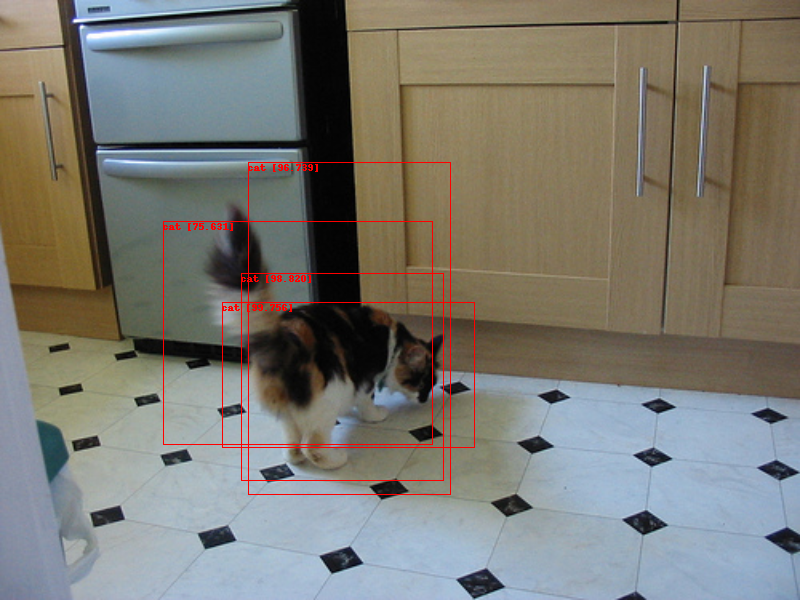

In [203]:
image = image_arr.cpu().data.numpy()
image = image[0, :, 0:int(image_info[0, 0]), 0:int(image_info[0, 1])].transpose(1, 2, 0) + voc_dataset.PIXEL_MEANS
image = image.round().astype(np.uint8)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
image_draw = ImageDraw.ImageDraw(image)

bbox_class = cls_preds.cpu().data.numpy().argmax(axis=1)
bbox_class_conf = cls_preds.cpu().data.numpy().max(axis=1)
bbox_adj = bbox_preds.cpu().data.numpy()

# nom-maximum suppression
bbox_preds_pre_nms = anchor_util.generate_proposals(bbox_org, bbox_adj)
keep_idx = nms.py_cpu_nms(np.hstack((bbox_preds_pre_nms, bbox_class.reshape(-1, 1))), .5)
bbox_preds_nms = bbox_preds_pre_nms[keep_idx]
bbox_class_nms = bbox_class[keep_idx]
bbox_class_conf_nms = bbox_class_conf[keep_idx]

for i in range(len(keep_idx)):
    if bbox_class_nms[i] == 0:
        continue
    class_name = voc_dataset.INDEX_TO_CLASS[bbox_class_nms[i]]
    start = bbox_class_nms[i] * 4
    end = start + 4
    image_draw.text(bbox_preds_nms[i, start:start+2], str("%s [%.3f]" % (class_name, bbox_class_conf_nms[i]*100.)), fill="red")
    image_draw.rectangle(bbox_preds_nms[i, start:end], outline="red")
image